In [1]:
from steady_state import *
from getpass import getpass
import arrow 
from dateutil import tz
from cognite.client import CogniteClient
from getpass import getpass
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

In [2]:
client = CogniteClient(
         api_key=getpass("Open Industrial Data API-KEY: "), 
         client_name="Steady State Detector notebook"
     )

Open Industrial Data API-KEY: ········


/Users/cimstordal/.local/share/virtualenvs/ssd-3IJuXT98/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Authenticated towards inferred project 'publicdata'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
start_date = datetime(2020, 4, 2)  # specify time series to pull from cdf
end_date = datetime(2020, 4, 10)
df = client.datapoints.retrieve(
     external_id="VAL_23-FT-92537-04:X.Value",
     start=start_date,
     end=end_date,
 ).to_pandas()
model = SSDetector(slope_threashold = 0.0007, 
                   state_transition_probability = 0.5,
                   number_particles = 200, n_timeless = 20)  # using the default params

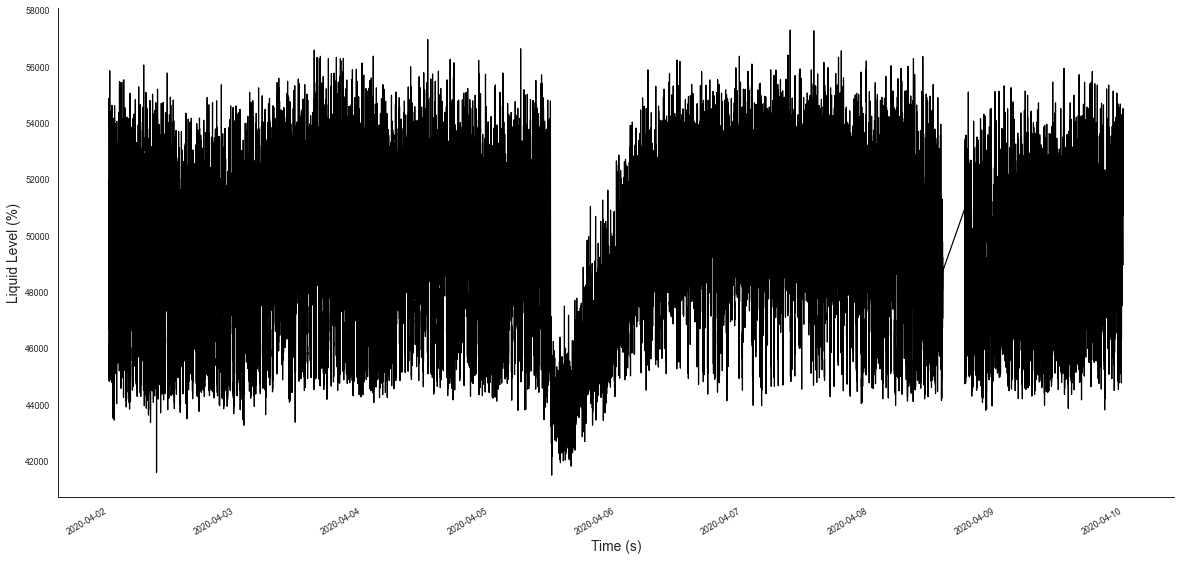

In [4]:
sns.set_style("white")
sns.set_context("paper")

ax = df.iloc[:,0].plot(figsize=(20,10), grid=False, 
                  color ='black')
ax.set_xlabel("Time (s)", fontsize = 'x-large')
ax.set_ylabel("Liquid Level (%)",fontsize = 'x-large')

sns.despine()
plt.savefig('ts')
plt.show()

In [5]:
model.train(np.squeeze(df.values, axis=1), show_results = True)

t:  1 
y_hat:  -2.1892239748042 
Pt:  0.0
t: 66471 y_hat: 61468.58238351911 Pt:  0.0005 0.0 0.0 y_hat: 1729.5071851936802 Pt:  0.0 0.046041.419380904415 Pt:  0.052829.73038354686 Pt:  0.0 -29799.965707119947 Pt:  0.0 38391.0427346152 Pt:  0.0 13337 y_hat: -68391.3111257373 Pt:  0.013810 y_hat: 71775.21218737357 Pt:  0.0 0.00.00.0 53805.294528839935 Pt:  0.0 55663.71747179776 Pt:  0.00.0 -3792.591848069627 Pt:  0.00.0Pt:  0.0 0.0 0.0Pt:  0.040946.561626923125 Pt:  0.047035.239668859074 Pt:  0.0Pt:  0.0 42569.49286482231 Pt:  0.0 0.0 56406.919371376265 Pt:  0.00.00.0y_hat: 57944.995066982534 Pt:  0.0y_hat: 47096.845005396266 Pt:  0.0 0.0Pt:  0.0 Pt:  0.00.0 0.0 39337.81268150186 Pt:  0.0Pt:  0.0 0.0 24095.273131751914 Pt:  0.00.0 13279.722601134315 Pt:  0.0 0.0 46180.58947713663 Pt:  0.0 0.090788.89944670696 Pt:  0.0 35911.40586393252 Pt:  0.0

In [6]:
df['y_hat'] = model.y_hat

In [7]:
df['y_hat'] = df.y_hat.shift(-1)

In [8]:
df['p'] = model.p_steady
df['p'] = df.p.shift(-1)

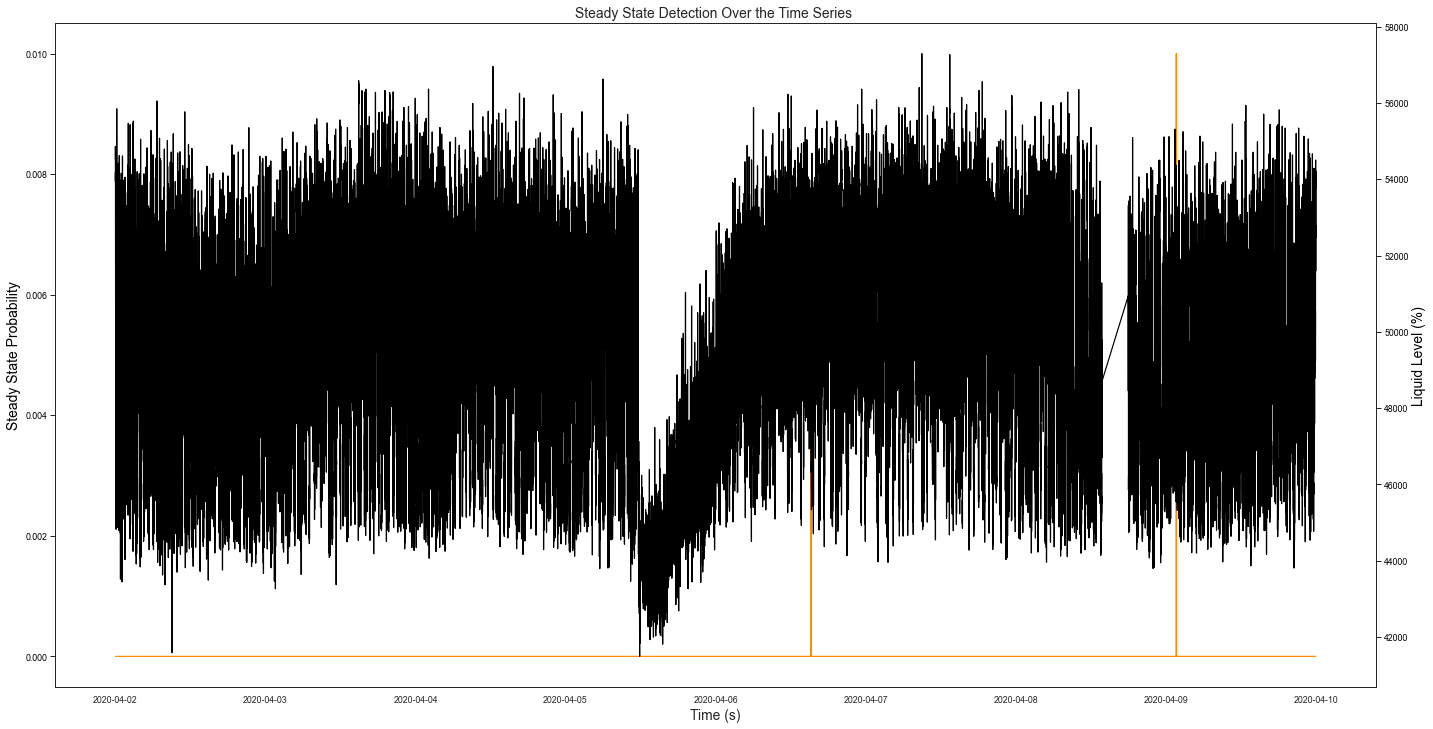

In [9]:
plt.rcParams["figure.figsize"] = (20, 10)
z = np.arange(0, len(df), 1)  # time scale
fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel("Time (s)", fontsize = 'x-large')
ax1.set_ylabel("Steady State Probability", color='black', fontsize = 'x-large')
ax1.plot(df.index, df.p[0 : len(z)], color='darkorange')  # noqa: E203
ax1.tick_params(axis="y", labelcolor='black')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel('Liquid Level (%)', color='black', fontsize = 'x-large')  # we already handled the x-label with ax1
ax2.plot(df.index, df.iloc[:,0].values, color='black')
ax2.tick_params(axis="y", labelcolor='black')
ax2.grid(False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Steady State Detection Over the Time Series ", fontsize = 'x-large')
plt.savefig('ss_result_2')
plt.show()

In [10]:
df['is_steady'] = 0 
steady_idx = df[df['p'] >0.8].index

In [11]:
df.loc[steady_idx, 'is_steady'] = 1 

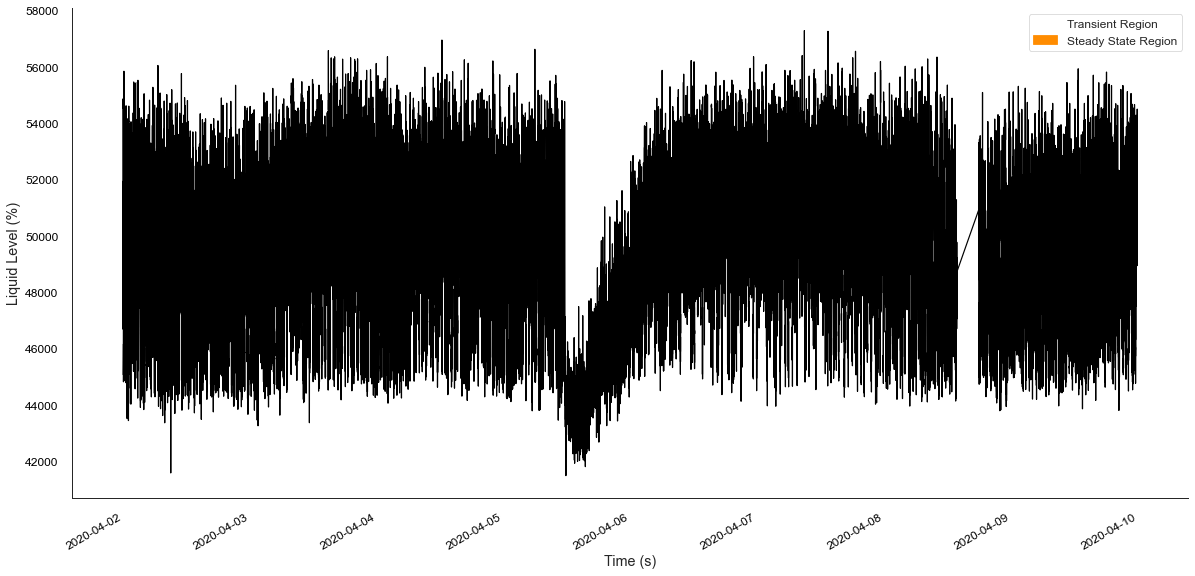

In [12]:
import matplotlib.patches as mpatches
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

red_patch = mpatches.Patch(color="white", label='Transient Region')
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['white', 'darkorange']
)
green_patch = mpatches.Patch(color='darkorange', label='Steady State Region')
ax = df['VAL_23-FT-92537-04:X.Value'].plot(color='black')
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
               df['is_steady'].values[np.newaxis],cmap = cmap,
               alpha=0.9)
ax.tick_params(direction='out', length=10, 
               width=10, colors='black', labelsize ='large')
ax.legend(fontsize = 'large', handles=[red_patch, green_patch])
ax.set_ylabel('Liquid Level (%)',fontsize = 'x-large' )
ax.set_xlabel('Time (s)',fontsize = 'x-large')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('ss_result')